In [1]:
%matplotlib inline
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.image as mpimg
import os,sys

In [2]:
# Helper functions

def load_image(infilename):
    data = mpimg.imread(infilename)
    return data

def img_float_to_uint8(img):
    rimg = img - np.min(img)
    rimg = (rimg / np.max(rimg) * 255).round().astype(np.uint8)
    return rimg

# Concatenate an image and its groundtruth
def concatenate_images(img, gt_img):
    nChannels = len(gt_img.shape)
    w = gt_img.shape[0]
    h = gt_img.shape[1]
    if nChannels == 3:
        cimg = np.concatenate((img, gt_img), axis=1)
    else:
        gt_img_3c = np.zeros((w, h, 3), dtype=np.uint8)
        gt_img8 = img_float_to_uint8(gt_img)          
        gt_img_3c[:,:,0] = gt_img8
        gt_img_3c[:,:,1] = gt_img8
        gt_img_3c[:,:,2] = gt_img8
        img8 = img_float_to_uint8(img)
        cimg = np.concatenate((img8, gt_img_3c), axis=1)
    return cimg

def img_crop(im, w, h):
    list_patches = []
    imgwidth = im.shape[0]
    imgheight = im.shape[1]
    is_2d = len(im.shape) < 3
    for i in range(0,imgheight,h):
        for j in range(0,imgwidth,w):
            if is_2d:
                im_patch = im[j:j+w, i:i+h]
            else:
                im_patch = im[j:j+w, i:i+h, :]
            list_patches.append(im_patch)
    return list_patches

In [3]:
# Loaded a set of images
root_dir = "../../data/training/"

image_dir = root_dir + "images/"
files = os.listdir(image_dir)
n = min(20, len(files)) # Load maximum 20 images
print("Loading " + str(n) + " images")
imgs = [load_image(image_dir + files[i]) for i in range(n)]

gt_dir = root_dir + "groundtruth/"
print("Loading " + str(n) + " images")
gt_imgs = [load_image(gt_dir + files[i]) for i in range(n)]

n = 10 # Only use 10 images for training

Loading 20 images
Loading 20 images


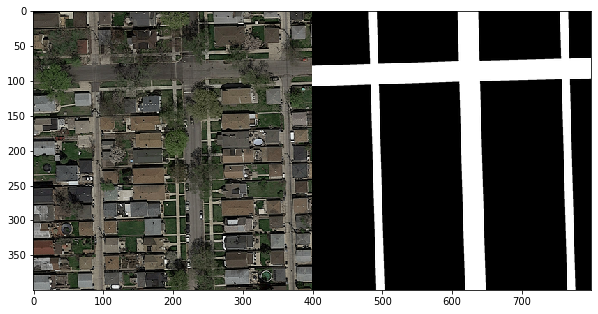

In [4]:
# Show #img_id image and its groundtruth image
img_id = 1
cimg = concatenate_images(imgs[img_id], gt_imgs[img_id])
fig1 = plt.figure(figsize=(10, 10))
plt.imshow(cimg, cmap='Greys_r')

# Preparation 1: segmentation and super-pixels

### abstract
1. over segment the image (should we use supervized learning?)
2. compute features associated to each node (aka. segment, aka. superpixel)

### TODOs
* [ ] supervized image segmentation
* [ ] features computation
* [ ]

### References
* [scikit-image for image segmentation](https://scikit-image.org/docs/dev/auto_examples/segmentation/plot_segmentations.html#sphx-glr-auto-examples-segmentation-plot-segmentations-py)

In [5]:
import skimage.data as data
import skimage.segmentation as seg
import skimage.filters as filters
import skimage.draw as draw
import skimage.color as color

In [6]:
def image_show(image, nrows=1, ncols=1, cmap='gray', figsize=5):
    fig, ax = plt.subplots(nrows=nrows, ncols=ncols, figsize=(figsize, figsize))
    ax.imshow(image, cmap='gray')
    ax.axis('off')
    return fig, ax

In [7]:
image = imgs[img_id]
ground_truth = gt_imgs[img_id]

Felzenszwalb number of segments: 686
SLIC number of segments: 199
Quickshift number of segments: 1070
Watershed number of segments: 256


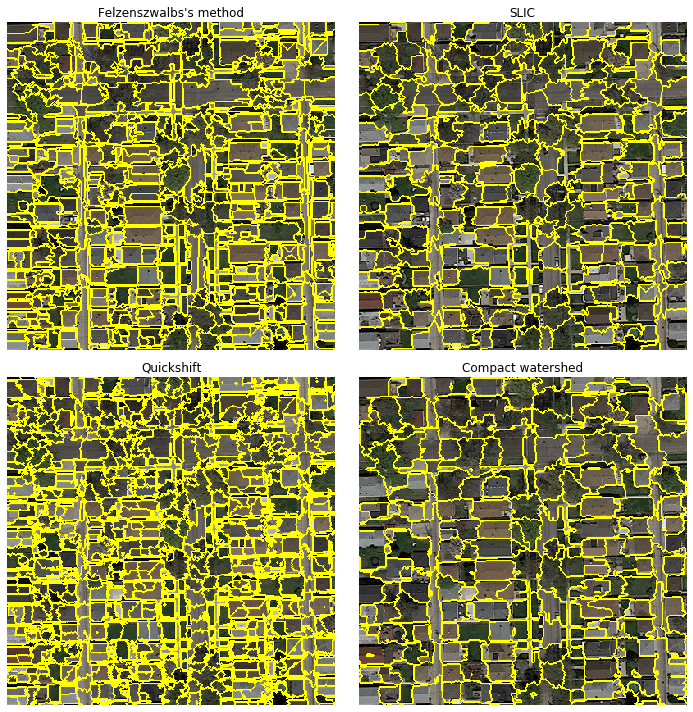

In [8]:
### source: https://scikit-image.org/docs/dev/auto_examples/segmentation/plot_segmentations.html
import matplotlib.pyplot as plt
import numpy as np

from skimage.data import astronaut
from skimage.color import rgb2gray
from skimage.filters import sobel
from skimage.segmentation import felzenszwalb, slic, quickshift, watershed
from skimage.segmentation import mark_boundaries
from skimage.util import img_as_float

img = img_as_float(image)

segments_fz = felzenszwalb(img, scale=100, sigma=0.5, min_size=50)
segments_slic = slic(img, n_segments=250, compactness=10, sigma=1)
segments_quick = quickshift(img, kernel_size=3, max_dist=6, ratio=0.5)
gradient = sobel(rgb2gray(img))
segments_watershed = watershed(gradient, markers=250, compactness=0.001)

print(f"Felzenszwalb number of segments: {len(np.unique(segments_fz))}")
print(f"SLIC number of segments: {len(np.unique(segments_slic))}")
print(f"Quickshift number of segments: {len(np.unique(segments_quick))}")
print(f"Watershed number of segments: {len(np.unique(segments_watershed))}")

fig, ax = plt.subplots(2, 2, figsize=(10, 10), sharex=True, sharey=True)

ax[0, 0].imshow(mark_boundaries(img, segments_fz))
ax[0, 0].set_title("Felzenszwalbs's method")
ax[0, 1].imshow(mark_boundaries(img, segments_slic))
ax[0, 1].set_title('SLIC')
ax[1, 0].imshow(mark_boundaries(img, segments_quick))
ax[1, 0].set_title('Quickshift')
ax[1, 1].imshow(mark_boundaries(img, segments_watershed))
ax[1, 1].set_title('Compact watershed')

for a in ax.ravel():
    a.set_axis_off()

plt.tight_layout()
plt.show()

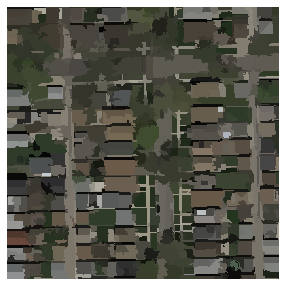

In [390]:
use_segments=segments_fz
# get unique segments from NxN image matrix
segments_ids = np.unique(use_segments)
# compute features for each segment (aka superpixel or node)
# features are: average color value, center (i,j) position... some more might be added
segments_features = []

rgb_avg = np.empty(image.shape)

for segment_id in segments_ids:
    indices = np.argwhere(use_segments == segment_id)
    cast_int = lambda x: int(x)
    (i, j) = np.mean(indices, axis=0).astype('int')
    rgb_values = image[use_segments == segment_id]
    (r, g, b) = np.mean(rgb_values, axis=0)
    segments_features += [[i, j, r, g, b]]

    rgb_avg[use_segments == segment_id] = [r,g,b] # rgb clusterized image
    #rgb_avg[use_segments == segment_id] = [r,r,r] # red layer
    #rgb_avg[use_segments == segment_id] = [g,g,g] # green layer
    #rgb_avg[use_segments == segment_id] = [b,b,b] # blue layer
    #rgb_avg[use_segments == segment_id] = [(r+g+b)/3] # grayscale
    
image_show(rgb_avg)
    
segments_features = np.array(segments_features)

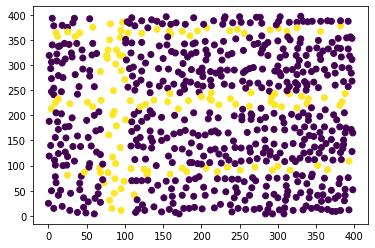

In [391]:
Y = []
for segment_id in segments_ids:
    Y += [np.mean(ground_truth[use_segments == segment_id])]
Y = np.array(Y)
Y[Y>=0.3] = 1
Y[Y<1] = 0
X = segments_features

def plot_X(X, c):
    plt.scatter(X[:,0], X[:,1], c=c)
    plt.show()
    
plot_X(X, c=Y)

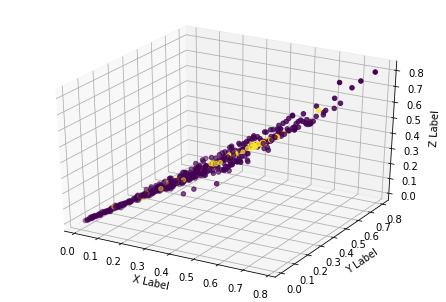

In [392]:
from mpl_toolkits.mplot3d import Axes3D
fig = plt.figure()
ax = Axes3D(fig)

ax.scatter(X[:,2], X[:,3], X[:,4], c=Y, marker='o')

ax.set_xlabel('X Label')
ax.set_ylabel('Y Label')
ax.set_zlabel('Z Label')

plt.show()

# Protocol 1: Unsupervized learning with graph

### abstract
1. from the superpixels, build a graph
2. apply k-means on graph

### TODOs
* [ ] define distance function
* [ ]

### References
* [scikit-image for image segmentation](https://scikit-image.org/docs/dev/auto_examples/segmentation/plot_segmentations.html#sphx-glr-auto-examples-segmentation-plot-segmentations-py)

In [393]:
def compute_number_connected_components(lamb: np.array, threshold: float = 1e-12):
    """ lamb: array of eigenvalues of a Laplacian
        Return:
        n_components (int): number of connected components.
    """
    n_components = sum(lamb<threshold)
    return n_components

def spectral_decomposition(laplacian: np.ndarray):
    """ Return:
        lamb (np.array): eigenvalues of the Laplacian
        U (np.ndarray): corresponding eigenvectors.
    """
    lamb, u = np.linalg.eigh(laplacian)
    return lamb, u

def compute_laplacian(adjacency: np.ndarray, normalize: bool):
    """ Return:
        L (n x n ndarray): combinatorial or symmetric normalized Laplacian.
    """
    d = np.sum(adjacency, axis=0);
    D = np.diag(d);
    L = D - adjacency;
    if (normalize):
        D_sqrt = np.diag(np.sqrt(1./d))
        L = D_sqrt @ L @ D_sqrt
    return L

def compute_model_accuracy(y, y_pred):
    size = y.shape[0]
    false_values = np.count_nonzero(y_pred.reshape(size, 1) - y.reshape(size, 1))
    diff = false_values / size
    accuracy = 1 - diff
    return 100 * accuracy

def calculate_f1(y, y_pred):
    y_sol = np.copy(y)
    nP = 2
    nS = 2
    P = np.zeros((nP, nS))
    R = np.zeros((nP, nS))
    F1 = np.zeros((nP, nS))
    M = len(y_sol)
    F1_overall = 0
    y_sol[np.where(y_sol==-1)] = 0
    y_pred[np.where(y_pred==-1)] = 0

    for i in range(nS):
        ci = sum(y_sol == i)
        for j in range(nP):
            true_value = 0
            for m in range(M):
                if y_sol[m] == i and y_pred[m] == j:
                    true_value = true_value + 1
            kj = sum(y_pred == j)
            if kj != 0:
                P[j,i] = true_value / kj
            if ci != 0:
                R[j,i] = true_value / ci
            if R[j,i]+P[j,i] != 0:
                F1[j,i] = (2*R[j,i]*P[j,i]) / (R[j,i]+P[j,i])
        F1_overall = F1_overall + ci / M * max(F1[:,i])
    return F1_overall * 100

In [ ]:
class SpectralClustering():
    def __init__(self, n_classes: int, normalize: bool):
        self.n_classes = n_classes
        self.normalize = normalize
        self.laplacian = None
        self.e = None
        self.U = None
        self.clustering_method =  KMeans(n_clusters=n_classes)
        
    def fit_predict(self, adjacency):
        """ Your code should be correct both for the combinatorial
            and the symmetric normalized spectral clustering.
            Return:
            y_pred (np.ndarray): cluster assignments.
        """
        self.laplacian = compute_laplacian(adjacency, normalize=self.normalize)
        self.e, self.U = spectral_decomposition(self.laplacian)
        Y = self.U[:,:self.n_classes];
        if (self.normalize):
            Y = (Y.T / np.linalg.norm(Y, axis=1)).T
        self.clustering_method.fit(Y)
        y_pred =  self.clustering_method.predict(Y)
            
        return y_pred

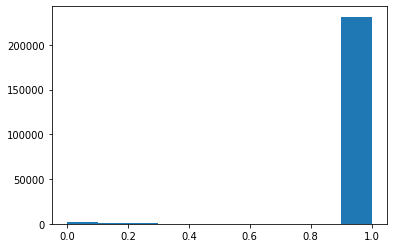

array([1., 1., 1., ..., 1., 1., 1.])

In [568]:
def redim(a, low=0, up=1):
        return np.interp(a, (a.min(), a.max()), (low, up))
def norm_center(a):
    return (a-np.mean(a))/np.std(a)

def my_dist(X, show=False):
    geo_dist = pdist(X[:,:2], metric='euclidean')
    geo_dist_cf = redim(pdist(X[:,:2], metric='euclidean'))
    #geo_dist_cf = redim(np.clip(norm_center(geo_dist), None, -3.), 0.1) # 65% deleted
    #geo_dist_cf = np.where(geo_dist < 0.05, geo_dist, 1)
    #plt.hist(geo_dist_cf)
    #plt.show()
    
    color_dist = pdist(X[:,2:], metric='euclidean')
    color_dist_cf = redim(np.exp(color_dist))
    #plt.hist(color_dist_cf)
    #plt.show()
    
    #computed_dist = color_dist_cf*geo_dist_cf
    #computed_dist = redim(computed_dist)

    computed_dist = color_dist_cf
    computed_dist[geo_dist_cf > 0.05] = 1
    
    if show:
        plt.hist(computed_dist)
        plt.show()
    
    #return computed_dist
    return computed_dist

my_dist(X, show=True)

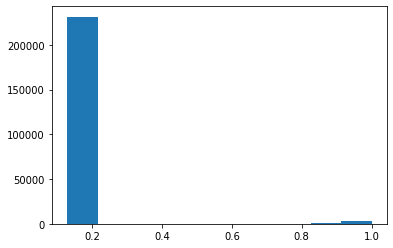

connected components: 1


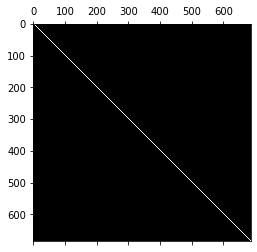

accuracy: 76.67638483965014%, F1: 76.58873213875704%


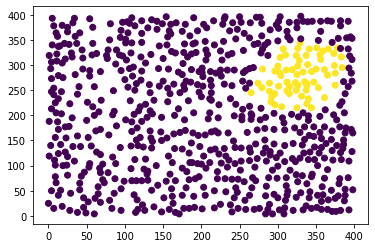

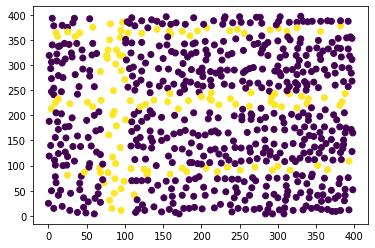

In [577]:
from scipy.spatial.distance import pdist, squareform

def epsilon_similarity_graph(X: np.ndarray, sigma_coeff=1, epsilon=0, distance_fn = None):
    """ X (n x d): coordinates of the n data points in R^d.
        sigma (float): width of the kernel
        epsilon (float): threshold
        Return:
        adjacency (n x n ndarray): adjacency matrix of the graph.
    """
    if distance_fn is None:
        distance_fn = lambda X: pdist(X, metric='euclidean')
    distances = distance_fn(X)
    sigma = sigma_coeff*np.mean(distances)
    weights_list = np.exp(-pow(distances,2) / (2*pow(sigma,2)))
    
    plt.hist(weights_list[weights_list>0.])
    plt.show()
    
    weight_matrix = squareform(weights_list)
    adjacency = np.where(weight_matrix > epsilon, weight_matrix, 0)
    return adjacency

adjacency = epsilon_similarity_graph(X, .5, .1, distance_fn = my_dist)

laplacian = compute_laplacian(adjacency, True)
lamb, u = spectral_decomposition(laplacian)

nb_cnctd = compute_number_connected_components(lamb)
print(f'connected components: {nb_cnctd}')

plt.spy(adjacency)
plt.show()

#####
spectral_clustering = SpectralClustering(n_classes=2, normalize=True)
y_pred =  spectral_clustering.fit_predict(adjacency)

print(f'accuracy: {compute_model_accuracy(Y, y_pred)}%, F1: {calculate_f1(Y, y_pred)}%')

plot_X(X, y_pred)

plot_X(X, Y) # for local compare

/opt/anaconda3/lib/python3.7/site-packages/networkx/drawing/nx_pylab.py:579: MatplotlibDeprecationWarning: 
The iterable function was deprecated in Matplotlib 3.1 and will be removed in 3.3. Use np.iterable instead.
  if not cb.iterable(width):


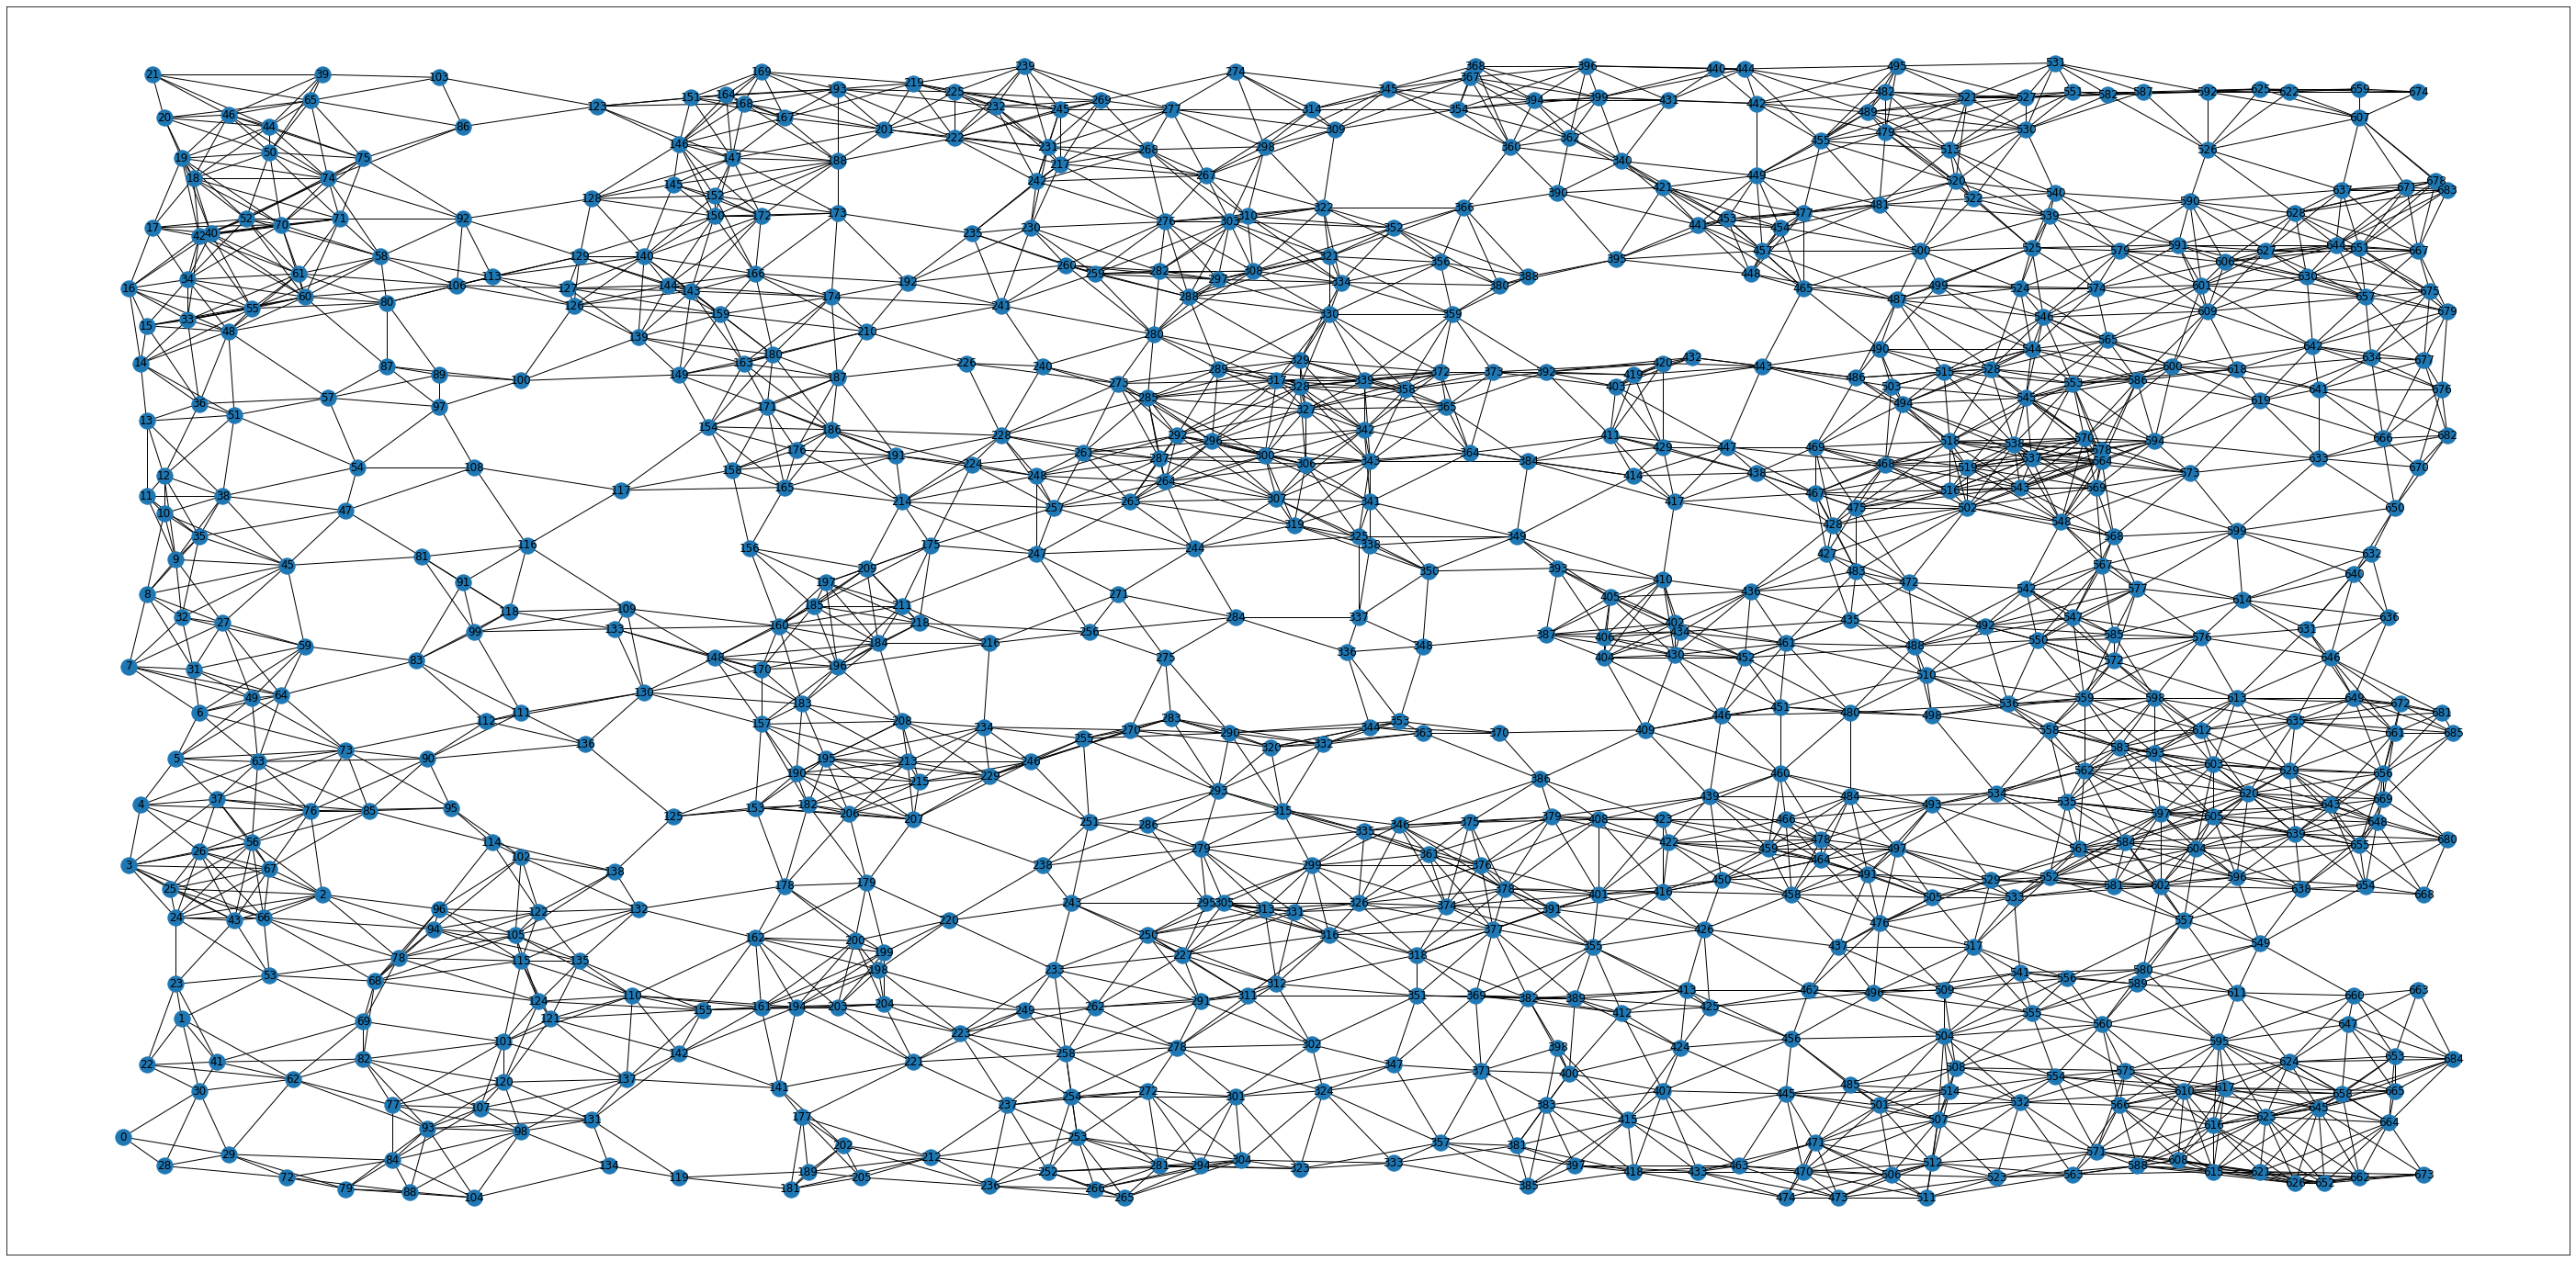

In [578]:
import networkx as nx
G = nx.from_numpy_matrix(np.where(adjacency > 0.5, adjacency, 0))
pos = {}
red = {}
for node in G.node:
    pos[node] = X[node, :2]
    red[node] = X[node, 2]
nx.set_node_attributes(G, name='red', values=red)
#G.nodes(data=True)
fig, ax = plt.subplots(figsize=(50,25))
nx.draw_networkx(G, pos=pos, ax=ax)

In [175]:
#from sklearn.manifold import TSNE
#X_embedded = TSNE(n_components=3).fit_transform(X)

In [176]:
#fig = plt.figure()
#ax = Axes3D(fig)
#for i in (0,1):
#    mask = Y == i
#    plt.scatter(X_embedded[mask, 0], X_embedded[mask, 1], label=i)
#ax.legend()
#plt.show()

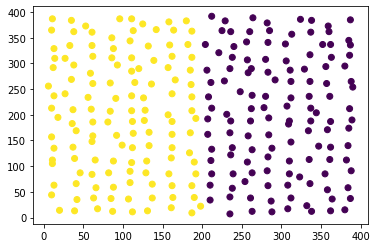

In [177]:
from sklearn.cluster import KMeans

kmeans = KMeans(n_clusters=2)
kmeans.fit(X)
y_pred = kmeans.labels_

plot_X(X, y_pred)

accuracy: 76.67638483965014%, F1: 76.58873213875704%


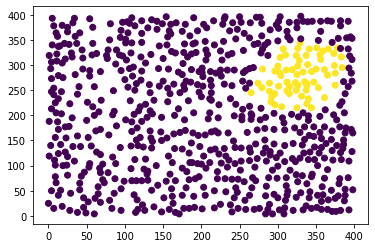

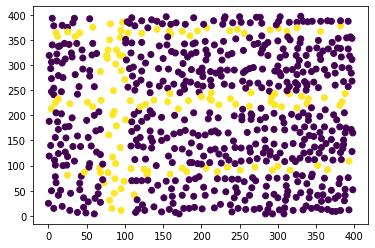

In [579]:
spectral_clustering = SpectralClustering(n_classes=2, normalize=True)
y_pred =  spectral_clustering.fit_predict(adjacency)

print(f'accuracy: {compute_model_accuracy(Y, y_pred)}%, F1: {calculate_f1(Y, y_pred)}%')

plot_X(X, y_pred)

plot_X(X, Y) # for local compare

# Protocol 1bis: Semi-Supervized learning with graph

### abstract
1. from previously constructed graph (see 1)
2. apply logistic regression on graph, using a 20% training ratio

In [580]:
import time

import networkx as nx
from sklearn.linear_model import LogisticRegression

import torch
import torch.nn as nn
import torch.nn.functional as F

import dgl.function as fn
from dgl import DGLGraph
from dgl.data.citation_graph import load_cora

np.random.seed(0)
torch.manual_seed(1)

In [581]:
features = torch.FloatTensor(X)
labels = torch.LongTensor(Y)

# Creating data indices for training and validation splits:
batch_size = 16
validation_split = .2
shuffle_dataset = True
random_seed= 42
dataset_size = len(X)
n_classes = 2

indices = list(range(dataset_size))
split = int(np.floor(validation_split * dataset_size))
if shuffle_dataset :
    np.random.seed(random_seed)
    np.random.shuffle(indices)
train_indices, val_indices = indices[split:], indices[:split]

features_train = torch.FloatTensor(X[train_indices])
labels_train = torch.FloatTensor(Y[train_indices])
features_test = torch.FloatTensor(X[val_indices])
labels_test = torch.FloatTensor(Y[val_indices])

In [582]:
# Fit a logistic regression model
# Your code here
def create_rg(
    random_state=0,
    solver='lbfgs',
    multi_class='multinomial',
    max_iter=200,
    C=1e6,
    warm_start=True,
):
    return LogisticRegression(
        random_state=random_state,
        solver=solver,
        multi_class=multi_class,
        max_iter=max_iter,
        C=C,
        warm_start=warm_start
    )
print(f'[Fun fact] Random accuracy would be: {1/n_classes}')

[Fun fact] Random accuracy would be: 0.5


In [591]:
clf = create_rg(C=1e1, max_iter=1000).fit(features_train, labels_train)

train_acc = clf.score(features_train, labels_train)
test_acc = clf.score(features_test, labels_test)

print('Train accuracy {:.4f} | Test accuracy {:.4f}'.format(train_acc, test_acc))

Train accuracy 0.8306 | Test accuracy 0.8175


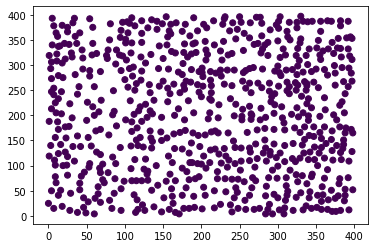

In [590]:
y_pred = clf.predict(features)
plot_X(X, c=y_pred)

# Protocol 2: Graph image segmentation (WIP)

### abstract
1. over segment the image (should we use supervized learning?)
2. create the graph from oversegmented image, using segments as super-pixels
3. obtain the bipartite graph (?)
4. classify from graph!

### TODOs
* [ ]

### References
* [graph-based-image-segmentation-in-python](https://sandipanweb.wordpress.com/2018/02/25/graph-based-image-segmentation-in-python/)

(75, 75, 3)


/opt/anaconda3/lib/python3.7/site-packages/skimage/transform/_warps.py:23: UserWarning: The default multichannel argument (None) is deprecated.  Please specify either True or False explicitly.  multichannel will default to False starting with release 0.16.
  warn('The default multichannel argument (None) is deprecated.  Please '


(<Figure size 360x360 with 1 Axes>,
 <matplotlib.axes._subplots.AxesSubplot at 0x1c36630590>)

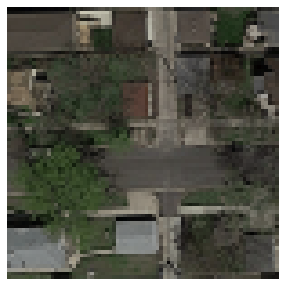

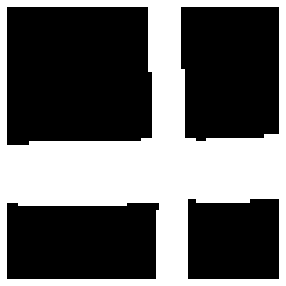

In [585]:
from skimage.transform import rescale, resize, downscale_local_mean

CUT_SIZE=150
RESCALE_F=0.5
image_rgb = np.copy(imgs[img_id][:CUT_SIZE, :CUT_SIZE, :])
image_rgb = rescale(image_rgb, RESCALE_F, anti_aliasing=False)
image_mask = gt_imgs[img_id][:CUT_SIZE, :CUT_SIZE]
image_mask = rescale(image_mask, RESCALE_F, anti_aliasing=False)
image_mask[image_mask != 0] = 1
print(image_rgb.shape)
image_show(image_rgb)
image_show(image_mask)

In [586]:
import numpy as np
from scipy import signal
import matplotlib.image as mpimg
import skimage.color as color
import dgl
import math
import networkx as nx

def gaussian_kernel(k, s = 0.5):
    # generate a (2k+1)x(2k+1) gaussian kernel with mean=0 and sigma = s
    probs = [np.exp(-z*z/(2*s*s))/np.sqrt(2*np.pi*s*s) for z in range(-k,k+1)]
    return np.outer(probs, probs)

def ij2id(i,j,w,h):
    return i+j*w
 
def create_graph(rgb, k=1., sigma=0.8, sz=1):
    # create the pixel graph with edge weights as dissimilarities
    gauss_kernel = gaussian_kernel(sz, sigma)
    for i in range(3):
        rgb[:,:,i] = signal.convolve2d(rgb[:,:,i], gauss_kernel, boundary='symm', mode='same')
    yuv = color.rgb2yiq(rgb)
    (w, h) = yuv.shape[:2]
    edges = {}
    for i in range(yuv.shape[0]):
        for j in range(yuv.shape[1]):
        #compute edge weight for nbd pixel nodes for the node i,j
            for i1 in range(i-1, i+2):
                for j1 in range(j-1, j+2):
                    if i1 == i and j1 == j:
                        continue
                    if i1 >= 0 and j1 >= 0 and j1 < h and i1 < w:
                        wt = np.abs(yuv[i,j,0]-yuv[i1,j1,0])
                        n1, n2 = ij2id(i,j,w,h), ij2id(i1,j1,w,h)
                        edges[n1, n2] = edges[n2, n1] = wt
    return edges

def build_dgl_graph(L, nb_nodes, threshold):
    g = dgl.DGLGraph()
    g.add_nodes(nb_nodes)
    for nodes, weight in L.items():
        if weight > threshold:
            g.add_edge(nodes[0], nodes[1])
    return g


def build_nx_graph(V, threshold = None):
    G = nx.Graph()
    (nodes, weights) = zip(*V.items())
    nodes = np.array(nodes)
    weights = np.array(weights)
    if threshold is None:
        threshold = np.mean(weights)
    G.add_edges_from(nodes[weights > threshold])
    return G

In [587]:
vertices = create_graph(image_rgb)
G = build_nx_graph(vertices)

In [27]:
vertices = create_graph(image_rgb)
_, values = zip(*vertices.items())
values = np.array(values)
mean = np.mean(values)
std = np.std(values)
(w, h) = image_rgb.shape[:2]
nb_nodes = w*h
print(nb_nodes, mean)
G = build_dgl_graph(vertices, nb_nodes, mean)

5625 0.018491747443752964


In [28]:
nb_nodes = G.number_of_nodes()
print('We have %d nodes.' % G.number_of_nodes())
print('We have %d edges.' % G.number_of_edges())

We have 5625 nodes.
We have 14576 edges.


In [29]:
cnb = nx.components.number_connected_components(G)
print(f'Nb of connected components: {cnb}')
graphs = list(nx.weakly_connected_component_subgraphs(G))

AttributeError: 'DGLGraph' object has no attribute 'is_directed'

In [ ]:
import torch
G_dgl = dgl.DGLGraph()
G_dgl.from_networkx(G)
G_dgl.ndata['feat'] = torch.eye(nb_nodes)

In [ ]:
import torch.nn.functional as F
import torch.nn as nn

# Define the message and reduce function
# NOTE: We ignore the GCN's normalization constant c_ij for this tutorial.
def gcn_message(edges):
    # The argument is a batch of edges.
    # This computes a (batch of) message called 'msg' using the source node's feature 'h'.
    return {'msg' : edges.src['h']}

def gcn_reduce(nodes):
    # The argument is a batch of nodes.
    # This computes the new 'h' features by summing received 'msg' in each node's mailbox.
    return {'h' : torch.sum(nodes.mailbox['msg'], dim=1)}

# Define the GCNLayer module
class GCNLayer(nn.Module):
    def __init__(self, in_feats, out_feats):
        super(GCNLayer, self).__init__()
        self.linear = nn.Linear(in_feats, out_feats)

    def forward(self, g, inputs):
        # g is the graph and the inputs is the input node features
        # first set the node features
        g.ndata['h'] = inputs
        # trigger message passing on all edges
        g.send(g.edges(), gcn_message)
        # trigger aggregation at all nodes
        g.recv(g.nodes(), gcn_reduce)
        # get the result node features
        h = g.ndata.pop('h')
        # perform linear transformation
        return self.linear(h)

In [ ]:
# Define a 2-layer GCN model
class GCN(nn.Module):
    def __init__(self, in_feats, hidden_size, num_classes):
        super(GCN, self).__init__()
        self.gcn1 = GCNLayer(in_feats, hidden_size)
        self.gcn2 = GCNLayer(hidden_size, num_classes)

    def forward(self, g, inputs):
        h = self.gcn1(g, inputs)
        h = torch.relu(h)
        h = self.gcn2(g, h)
        return h
# The first layer transforms input features of size of 34 to a hidden size of 5.
# The second layer transforms the hidden layer and produces output features of
# size 2, corresponding to the two groups of the karate club.
net = GCN(nb_nodes, 5, 2)

In [ ]:
tr_idx = int(nb_nodes/2)
labels_np = np.array(image_mask).flatten()[:tr_idx]
labeled_nodes_np = np.array(range(0,tr_idx))
print(labels_np)
print(labeled_nodes_np)

In [ ]:
inputs = torch.eye(nb_nodes)
labeled_nodes = torch.tensor(labeled_nodes_np)  # only the instructor and the president nodes are labeled
labels = torch.tensor(labels_np.astype('long'))  # their labels are different

> TODO: train graph with labels????

In [ ]:
optimizer = torch.optim.Adam(net.parameters(), lr=0.01)
all_logits = []
for epoch in range(100):
    logits = net(G, inputs)
    # we save the logits for visualization later
    all_logits.append(logits.detach())
    logp = F.log_softmax(logits, 1)
    # we only compute loss for labeled nodes
    loss = F.nll_loss(logp[labeled_nodes], labels)

    optimizer.zero_grad()
    loss.backward()
    optimizer.step()

    print('Epoch %d | Loss: %.4f' % (epoch, loss.item()))

> TODO: visualize results of classification

In [ ]:
EPOCH_ID=29
predictions_val = all_logits[EPOCH_ID].numpy()
predictions = np.zeros(predictions_val.shape[0])
for i, p in enumerate(predictions_val):
    predictions[i] = p.argmax()
predicted_mask = np.reshape(predictions, image_rgb.shape[:2])
image_show(predicted_mask)

In [ ]:
# test the functions work as expected
to_array = np.array(image_mask).flatten()
#(w, h) = image_mask.shape[:2]
#back_array = np.zeros(image_mask.shape[:2])
#for _id, p in enumerate(to_array):
#    (i, j) = id2ij(_id, w, h)
#    back_array[(j, i-1)] = to_array[_id]
back_array = np.reshape(to_array, image_mask.shape[:2])
image_show(back_array)
image_show(image_mask)